In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image
# default: 100
mpl.rcParams['figure.dpi'] = 150
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## summary

- transformer-based language model
    - 目前最核心的一个能力：text generation，尤其对于 gpt 而言；
- openai gpt2
    - https://openai.com/research/better-language-models
- 预训练之后，被 prompt（context）激活的广泛的能力

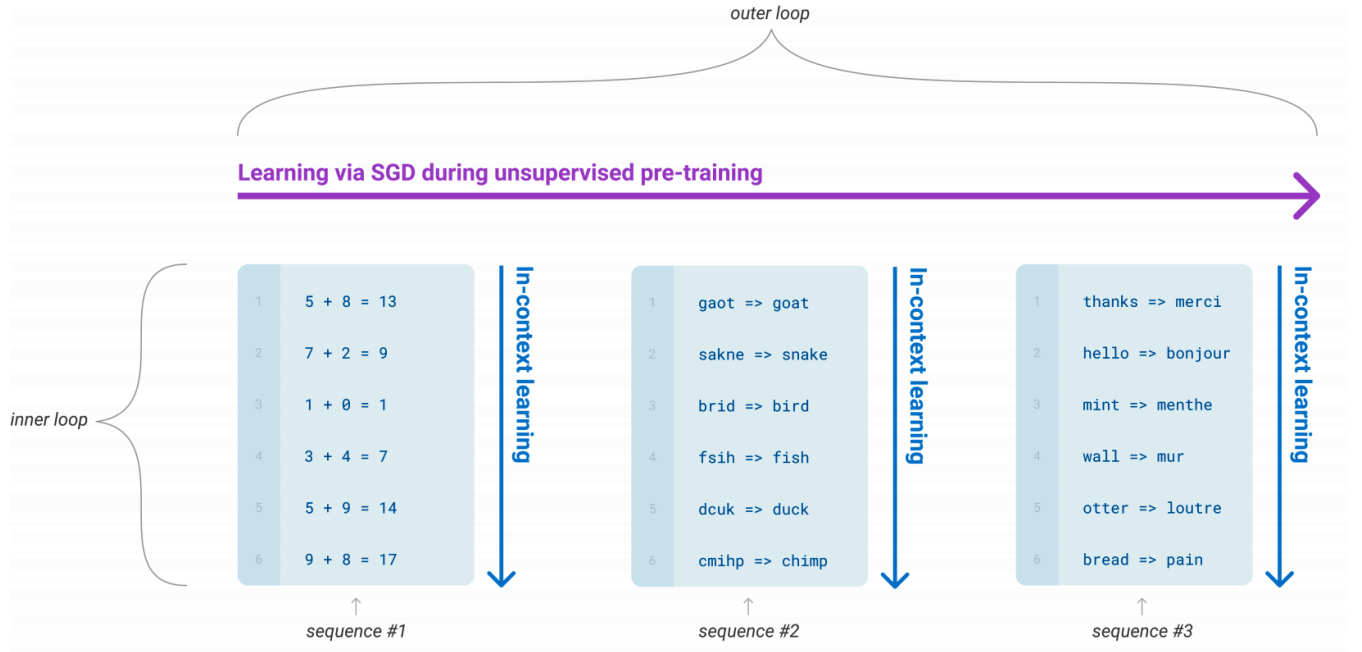

In [2]:
Image('../imgs/pretrain.png', width=600)

### pretrained model

- on English language
- causal language modeling (CLM) objective. (多分类问题）
- Language Models are Unsupervised Multitask Learners
    - https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf

### decoding strategies

- converting the model’s probabilistic output（vocab size classification） to text
    - iteratively，意味着更多的计算量
    - quality & diversity
- greedy search decoding：搜狗输入法，每次都用top1的候选
- beam search decoding
- sampling methods
- top-k & nucleus sampling

- (autoregressive or causal) language models

- $\textbf{x}=x_1,x_2,\cdots,x_k. \textbf{y}=y_1,y_2,\cdots,y_t.$
    - chain rule of probability to factorize it as a product of conditional probabilities
$$
\begin{split}
P(\textbf{y}|\textbf{x})&=P(y_1,y_2,\cdots,y_t|\textbf{x})\\
&=\Pi_{t=1}^Np(y_t|y_{\lt t}, \textbf{x})\quad (y_{\lt t}=y_{1,2,\cdots,t-1})
\end{split}
$$

- 单向的，从左至右的，（BERT 的 B 表示的含义就是 bidirectional）

- 具体的解码过程：
    
$$
\begin{split}
&p(y_t=w_i|y_{\lt t}, x)=\text{softmax}(z_{t,i})\\
&\hat{\textbf{y}}={\arg\max}_{\textbf{y}}P(\textbf{y}|\textbf{x})
\end{split}
$$

## gpt2

|model        |参数量       |hidden dim        |  block 数量 | 
| ----------- |----------- | ---------------- | -----------| 
|gpt2         |124M        |    768  (64\*12) |          12|
|gpt2-medium  |355M        |    1024 (64\*16) |          24|
|gpt2-large   |774M        |    1280 (64\*20) |          36|
|gpt2-xl      |1.56B       |    1600 (64\*25) |          48|

In [3]:
from transformers import AutoModelForCausalLM
from transformers_utils import get_params

In [4]:
# 'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'
# 'gpt2': https://huggingface.co/gpt2
# 'gpt2-medium': https://huggingface.co/gpt2-medium
# 'gpt2-large': https://huggingface.co/gpt2-large
# 'gpt2-xl': https://huggingface.co/gpt2-xl
# 没有 case/uncased 之分
model_ckpt = 'gpt2-xl'
config = AutoConfig.from_pretrained(model_ckpt)
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
# model_clm = AutoModelForCausalLM.from_pretrained(model_ckpt)
print(format(get_params(model), ','))

1,557,611,200


In [5]:
config

GPT2Config {
  "_name_or_path": "gpt2-xl",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1600,
  "n_head": 25,
  "n_inner": null,
  "n_layer": 48,
  "n_positions": 1024,
  "output_past": true,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.28.1",
  "use_cache": true,
  "vocab_size": 50257
}

In [6]:
model

GPT2Model(
  (wte): Embedding(50257, 1600)
  (wpe): Embedding(1024, 1600)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-47): 48 x GPT2Block(
      (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
)

### tokenizer

In [7]:
tokenizer

GPT2TokenizerFast(name_or_path='gpt2-xl', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True)

In [17]:
print(tokenizer.special_tokens_map)
print(tokenizer.special_tokens_map_extended)

print(tokenizer.encode('<|endoftext|>'))
print(tokenizer.decode(50256))

print(tokenizer.encode('  '))
print(tokenizer.decode(220))

# 大小写敏感
print(tokenizer.encode('Hello'))
print(tokenizer.encode('hello'))
print(tokenizer.encode(' hello'))
print(tokenizer.decode(23748))
print(tokenizer.encode(' hello'))
print(tokenizer.encode('  hello'))
print(tokenizer.encode('   hello'))

{'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}
{'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}
[50256]
<|endoftext|>
[220, 220]
 
[15496]
[31373]
[23748]
 hello
[23748]
[220, 23748]
[220, 220, 23748]


|Token ID	|  String                          | 
|-----------|----------------------------------|
|39177	    | ItemThumbnailImage               |
|30210	    | guiActiveUnfocused               |
|39755	    | isSpecialOrderable               |
|31576	    | externalActionCode               |
|39753	    | quickShipAvailable               |
|39757	    | channelAvailability              |
|36174	    | RandomRedditorWithNo             |
|30899	    | cloneembedreportprint            |
|40242	    | BuyableInstoreAndOnline          |
|30906	    | rawdownloadcloneembedreportprint |

In [18]:
print(tokenizer.encode('ItemThumbnailImage'))
print(tokenizer.encode('rawdownloadcloneembedreportprint'))

[39177]
[30906]


In [19]:
tokenizer('My favorite color is chartreuse')

{'input_ids': [3666, 4004, 3124, 318, 8262, 260, 1904], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [20]:
tokenizer.encode(' chartreuse')

[8262, 260, 1904]

### attention_mask

- 更好地构造结构化，批次化输入 (tensor, shape 是一定的)

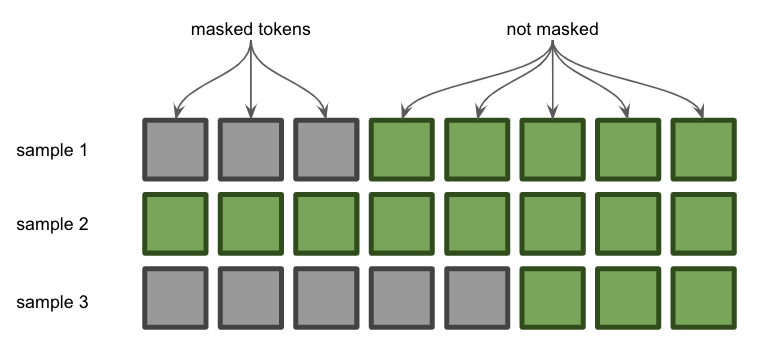

In [21]:
Image('../imgs/attention_mask.png')

In [22]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')

context = tokenizer('It will rain in the', return_tensors='pt')
context
# prediction = gpt2.generate(**context, max_length=10)
# tokenizer.decode(prediction[0])

{'input_ids': tensor([[1026,  481, 6290,  287,  262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [24]:
# tokenizer.padding_side = "left"
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token

sentences = ["It will rain in the",
            "I want to eat a big bowl of",
            "My dog is"]
inputs = tokenizer(sentences, return_tensors="pt", padding=True)
print(inputs.input_ids)
print(inputs.attention_mask)
# output_sequences = gpt2.generate(**inputs)

# for seq in output_sequences:
#     print(tokenizer.decode(seq))


tensor([[ 1026,   481,  6290,   287,   262, 50256, 50256, 50256],
        [   40,   765,   284,  4483,   257,  1263,  9396,   286],
        [ 3666,  3290,   318, 50256, 50256, 50256, 50256, 50256]])
tensor([[1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 0, 0]])


## forward

- GPT2Model
    - wte: word token embedding
    - wpe: word position embedding
- LMHead
    - mlp: hidden_state => vocab_size

In [25]:
model_ckpt = 'gpt2-xl'
config = AutoConfig.from_pretrained(model_ckpt)
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
model_clm = AutoModelForCausalLM.from_pretrained(model_ckpt).to(device)

In [26]:
model

GPT2Model(
  (wte): Embedding(50257, 1600)
  (wpe): Embedding(1024, 1600)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-47): 48 x GPT2Block(
      (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
)

In [27]:
model_clm

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50257, bias=False)
)

In [28]:
# 大小写是不同的token，
# 空格也是token
input_txt = "A long long time ago"
model_inputs = tokenizer(input_txt, return_tensors='pt')
model_inputs

{'input_ids': tensor([[  32,  890,  890,  640, 2084]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [29]:
input_ids = model_inputs['input_ids'].to(device)

In [34]:
output = model_clm(input_ids=input_ids)
print(output.logits.shape)
output.logits

torch.Size([1, 5, 50257])


tensor([[[ 1.5445,  2.5812,  0.6197,  ..., -7.4777, -5.5282,  0.6108],
         [ 1.0344,  1.5582, -2.5840,  ..., -6.3941, -2.5380, -1.0215],
         [ 2.0070,  2.3330, -1.1671,  ..., -7.7938, -3.9385,  1.0949],
         [ 5.6171,  4.4350, -2.1919,  ..., -7.9733, -5.2310,  1.6343],
         [ 4.8450,  5.3529, -0.7294,  ..., -7.7071, -3.8473,  2.5437]]],
       device='cuda:0', grad_fn=<UnsafeViewBackward0>)

### model.transformer()

`(transformer): GPT2Model`

In [36]:
model_clm.eval()
print(model_clm.transformer(input_ids).last_hidden_state.shape)
model_clm.transformer(input_ids).last_hidden_state

torch.Size([1, 5, 1600])


tensor([[[-0.5478,  0.0327,  0.7691,  ..., -4.5986,  0.2638,  0.1780],
         [-1.0570, -0.8408,  0.8223,  ..., -1.3309,  1.0921,  0.7939],
         [-0.5805, -1.1760,  0.4954,  ..., -1.3462,  1.2957,  1.2741],
         [-0.2789, -1.5347,  0.6579,  ..., -1.6087,  1.1029,  0.9785],
         [ 0.2617,  0.0104,  0.6141,  ..., -1.6620,  1.4646,  0.6588]]],
       device='cuda:0', grad_fn=<ViewBackward0>)

### 自定义（model.transformer()）

In [38]:
model.config

GPT2Config {
  "_name_or_path": "gpt2-xl",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1600,
  "n_head": 25,
  "n_inner": null,
  "n_layer": 48,
  "n_positions": 1024,
  "output_past": true,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.28.1",
  "use_cache": true,
  "vocab_size": 50257
}

In [39]:
def gpt2_transformer_forward(model, input_ids):
    model.eval()
    input_shape = input_ids.size()
    input_ids = input_ids.view(-1, input_shape[-1])
    batch_size = input_ids.shape[0]
    
    past_length = 0
    past_key_values = tuple([None] * len(model.h))
    position_ids = torch.arange(past_length, input_shape[-1] + past_length, dtype=torch.long, device=device)
    position_ids = position_ids.unsqueeze(0).view(-1, input_shape[-1])
    
    encoder_attention_mask = None
    
    # embedding
    inputs_embeds = model.wte(input_ids)
    position_embeds = model.wpe(position_ids)
    hidden_states = inputs_embeds + position_embeds
    hidden_states = model.drop(hidden_states)
    output_shape = input_shape + (hidden_states.size(-1),)
    
    head_mask = model.get_head_mask(None, model.config.n_layer)
    
    for i, (block, layer_past) in enumerate(zip(model.h, past_key_values)):
        outputs = block(
                    hidden_states,
                    layer_past=layer_past,
                    head_mask=head_mask[i],
                )
        hidden_states = outputs[0]
    hidden_states = model.ln_f(hidden_states)
    hidden_states = hidden_states.view(output_shape)
    return hidden_states

In [40]:
with torch.no_grad():
    print(gpt2_transformer_forward(model_clm.transformer, input_ids))

tensor([[[-0.5478,  0.0327,  0.7691,  ..., -4.5986,  0.2638,  0.1780],
         [-1.0570, -0.8408,  0.8223,  ..., -1.3309,  1.0921,  0.7939],
         [-0.5805, -1.1760,  0.4954,  ..., -1.3462,  1.2957,  1.2741],
         [-0.2789, -1.5347,  0.6579,  ..., -1.6087,  1.1029,  0.9785],
         [ 0.2617,  0.0104,  0.6141,  ..., -1.6620,  1.4646,  0.6588]]],
       device='cuda:0')


### lmhead_model(input_ids)

In [41]:
model_clm(input_ids=input_ids).logits

tensor([[[ 1.5445,  2.5812,  0.6197,  ..., -7.4777, -5.5282,  0.6108],
         [ 1.0344,  1.5582, -2.5840,  ..., -6.3941, -2.5380, -1.0215],
         [ 2.0070,  2.3330, -1.1671,  ..., -7.7938, -3.9385,  1.0949],
         [ 5.6171,  4.4350, -2.1919,  ..., -7.9733, -5.2310,  1.6343],
         [ 4.8450,  5.3529, -0.7294,  ..., -7.7071, -3.8473,  2.5437]]],
       device='cuda:0', grad_fn=<UnsafeViewBackward0>)

### 自定义 lmhead_model forward

In [42]:
def gpt2_clm_forward(model, input_ids):
    model.eval()
    transformer_outputs = model.transformer(input_ids)
    hidden_states = transformer_outputs[0]
    print(hidden_states.shape)
    lm_logits = model.lm_head(hidden_states)
    print(lm_logits.shape)
    return lm_logits

In [43]:
gpt2_clm_forward(model_clm, input_ids)

torch.Size([1, 5, 1600])
torch.Size([1, 5, 50257])


tensor([[[ 1.5445,  2.5812,  0.6197,  ..., -7.4777, -5.5282,  0.6108],
         [ 1.0344,  1.5582, -2.5840,  ..., -6.3941, -2.5380, -1.0215],
         [ 2.0070,  2.3330, -1.1671,  ..., -7.7938, -3.9385,  1.0949],
         [ 5.6171,  4.4350, -2.1919,  ..., -7.9733, -5.2310,  1.6343],
         [ 4.8450,  5.3529, -0.7294,  ..., -7.7071, -3.8473,  2.5437]]],
       device='cuda:0', grad_fn=<UnsafeViewBackward0>)